In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 

In [2]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.   ,  2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133,
        0.067,  0.033,0.37,7.4])

In [3]:
rs.sort()

In [ ]:
np.log(rs)

In [4]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
WN2 = np.dot(WN, WN)
# prob = WN[:,1858]
prob = WN2[:,1858]
prob_2d = prob.reshape(-1,1)

In [5]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
#     weight = prob[v]
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [6]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [7]:
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
           5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
        0.067:3,  0.033:3, 0.37:2,7.4:0}

In [28]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []

for r_idx in range(21):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
#         g_i_new = g_i[:,10:] * prob_2d
        g_i_new = g_i[:,53:]
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

0.025 3
0.033 3
0.05 3
0.067 3
0.1 2
0.133 2
0.2 2
0.286 2
0.37 2
0.5 1
0.667 1
1.0 1
1.333 1
2.0 1
2.5 1
3.333 1
5.0 0
7.4 0
10.0 0
13.333 0
20.0 0


In [29]:
from torch.utils.data import random_split
all_data_len = len(dataset)
train_data, test_data = random_split(dataset, [int(all_data_len*0.8), int(all_data_len*0.2)])

In [30]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)     
        self.conv2 = GCNConv(128, 64) 
        self.conv3 = GCNConv(64, 16) 
        self.conv4 = GCNConv(16, 8) 
        self.fc = torch.nn.Linear(8, 1)


    """
        hyperparameters:
        - number of hidden layers
        - number of hidden channels
        - dropout rate (now it's zero)
        - learning rate <- most important to tune
        - weight decay
        - etc etc.
    """

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
#         edge_index, edge_weight = add_self_loops(edge_index, edge_attr=edge_weight, num_nodes=x.size(0))

        x = self.conv1(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv2(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv3(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)
        
        x = self.conv4(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=7).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
        
        # Calculate weights based on extremes
#         weights = calculate_weights(label, -2.8,2)
        # Use the custom weighted loss function
#         loss = weighted_mse_loss(output, label, weights)
        loss = F.mse_loss(output, label) 
#         loss = F.cross_entropy(output, label)
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        
        optimizer.step() 
        results.append(output)
    
    return loss_all / len(myloader.dataset), results, y_true



counter = 0
count_epochs = 0
best = float("inf")
epochs = 50
patience = 10
loss_ep= []
 
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    loss, myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
#     ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss))
    if loss < best:
        best = loss
        counter = 0
    else:
        counter += 1
        count_epochs += 1
        
    if counter > patience:
        break
        # print(f"Epoch: {​​​​​​epoch:03d}​​​​​​, Loss: {​​​​​​loss:.4f}​​​​​​")
#     scheduler.step()
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
print("\n", "Stopped early at epoch: ", count_epochs)


Epoch: 001, Loss: 9.9725:   2%|▎                 | 1/50 [00:53<43:36, 53.40s/it]

Epoch: 001, Loss: 9.97248


Epoch: 002, Loss: 3.6462:   4%|▋                 | 2/50 [01:45<42:11, 52.75s/it]

Epoch: 002, Loss: 3.64621


Epoch: 003, Loss: 4.1543:   6%|█                 | 3/50 [02:37<41:08, 52.51s/it]

Epoch: 003, Loss: 4.15432


Epoch: 004, Loss: 3.4617:   8%|█▍                | 4/50 [03:30<40:09, 52.38s/it]

Epoch: 004, Loss: 3.46165


Epoch: 005, Loss: 3.2037:  10%|█▊                | 5/50 [04:19<38:30, 51.35s/it]

Epoch: 005, Loss: 3.20373


Epoch: 006, Loss: 3.0269:  12%|██▏               | 6/50 [05:03<35:48, 48.83s/it]

Epoch: 006, Loss: 3.02692


Epoch: 007, Loss: 2.5931:  14%|██▌               | 7/50 [05:47<33:53, 47.28s/it]

Epoch: 007, Loss: 2.59312


Epoch: 008, Loss: 2.0287:  16%|██▉               | 8/50 [06:38<33:48, 48.30s/it]

Epoch: 008, Loss: 2.02871


Epoch: 009, Loss: 2.0123:  18%|███▏              | 9/50 [07:29<33:44, 49.37s/it]

Epoch: 009, Loss: 2.01234


Epoch: 010, Loss: 2.2891:  20%|███▍             | 10/50 [08:22<33:33, 50.33s/it]

Epoch: 010, Loss: 2.28907


Epoch: 011, Loss: 1.9655:  22%|███▋             | 11/50 [09:14<33:06, 50.93s/it]

Epoch: 011, Loss: 1.96545


Epoch: 012, Loss: 1.7608:  24%|████             | 12/50 [10:07<32:32, 51.39s/it]

Epoch: 012, Loss: 1.76083


Epoch: 013, Loss: 1.6497:  26%|████▍            | 13/50 [10:59<31:51, 51.67s/it]

Epoch: 013, Loss: 1.64967


Epoch: 014, Loss: 1.6860:  28%|████▊            | 14/50 [11:51<31:02, 51.74s/it]

Epoch: 014, Loss: 1.68604


Epoch: 015, Loss: 1.7870:  30%|█████            | 15/50 [12:43<30:14, 51.85s/it]

Epoch: 015, Loss: 1.78696


Epoch: 016, Loss: 1.2916:  32%|█████▍           | 16/50 [13:36<29:33, 52.16s/it]

Epoch: 016, Loss: 1.29162


Epoch: 017, Loss: 1.2550:  34%|█████▊           | 17/50 [14:29<28:46, 52.33s/it]

Epoch: 017, Loss: 1.25502


Epoch: 018, Loss: 1.1396:  36%|██████           | 18/50 [15:21<27:58, 52.45s/it]

Epoch: 018, Loss: 1.13964


Epoch: 019, Loss: 1.0469:  38%|██████▍          | 19/50 [16:14<27:09, 52.55s/it]

Epoch: 019, Loss: 1.04691


Epoch: 020, Loss: 1.1385:  40%|██████▊          | 20/50 [17:07<26:17, 52.57s/it]

Epoch: 020, Loss: 1.13846


Epoch: 021, Loss: 0.9280:  42%|███████▏         | 21/50 [17:59<25:25, 52.62s/it]

Epoch: 021, Loss: 0.92795


Epoch: 022, Loss: 1.0025:  44%|███████▍         | 22/50 [18:52<24:32, 52.59s/it]

Epoch: 022, Loss: 1.00251


Epoch: 023, Loss: 0.9050:  46%|███████▊         | 23/50 [19:44<23:39, 52.58s/it]

Epoch: 023, Loss: 0.90504


Epoch: 024, Loss: 0.9321:  48%|████████▏        | 24/50 [20:37<22:43, 52.46s/it]

Epoch: 024, Loss: 0.93207


Epoch: 025, Loss: 0.8247:  50%|████████▌        | 25/50 [21:29<21:54, 52.57s/it]

Epoch: 025, Loss: 0.82466


Epoch: 026, Loss: 0.8684:  52%|████████▊        | 26/50 [22:22<20:58, 52.42s/it]

Epoch: 026, Loss: 0.86842


Epoch: 027, Loss: 0.7913:  54%|█████████▏       | 27/50 [23:14<20:09, 52.57s/it]

Epoch: 027, Loss: 0.79130


Epoch: 028, Loss: 0.7942:  56%|█████████▌       | 28/50 [24:07<19:15, 52.52s/it]

Epoch: 028, Loss: 0.79423


Epoch: 029, Loss: 0.8888:  58%|█████████▊       | 29/50 [24:59<18:22, 52.49s/it]

Epoch: 029, Loss: 0.88878


Epoch: 030, Loss: 0.7596:  60%|██████████▏      | 30/50 [25:52<17:30, 52.50s/it]

Epoch: 030, Loss: 0.75957


Epoch: 031, Loss: 0.6780:  62%|██████████▌      | 31/50 [26:44<16:38, 52.54s/it]

Epoch: 031, Loss: 0.67798


Epoch: 032, Loss: 0.8021:  64%|██████████▉      | 32/50 [27:37<15:45, 52.51s/it]

Epoch: 032, Loss: 0.80205


Epoch: 033, Loss: 0.7304:  66%|███████████▏     | 33/50 [28:29<14:52, 52.51s/it]

Epoch: 033, Loss: 0.73040


Epoch: 034, Loss: 0.7314:  68%|███████████▌     | 34/50 [29:22<14:02, 52.63s/it]

Epoch: 034, Loss: 0.73136


Epoch: 035, Loss: 0.6145:  70%|███████████▉     | 35/50 [30:16<13:14, 52.97s/it]

Epoch: 035, Loss: 0.61452


Epoch: 036, Loss: 0.6102:  72%|████████████▏    | 36/50 [31:11<12:28, 53.48s/it]

Epoch: 036, Loss: 0.61024


Epoch: 037, Loss: 0.6573:  74%|████████████▌    | 37/50 [32:05<11:38, 53.73s/it]

Epoch: 037, Loss: 0.65730


Epoch: 038, Loss: 0.5984:  76%|████████████▉    | 38/50 [32:58<10:42, 53.55s/it]

Epoch: 038, Loss: 0.59838


Epoch: 039, Loss: 0.6456:  78%|█████████████▎   | 39/50 [33:52<09:49, 53.59s/it]

Epoch: 039, Loss: 0.64559


Epoch: 040, Loss: 0.6085:  80%|█████████████▌   | 40/50 [34:45<08:54, 53.48s/it]

Epoch: 040, Loss: 0.60849


Epoch: 041, Loss: 0.5827:  82%|█████████████▉   | 41/50 [35:38<07:59, 53.27s/it]

Epoch: 041, Loss: 0.58271


Epoch: 042, Loss: 0.6084:  84%|██████████████▎  | 42/50 [36:31<07:04, 53.12s/it]

Epoch: 042, Loss: 0.60835


Epoch: 043, Loss: 0.6988:  86%|██████████████▌  | 43/50 [37:23<06:10, 52.92s/it]

Epoch: 043, Loss: 0.69884


Epoch: 044, Loss: 0.5962:  88%|██████████████▉  | 44/50 [38:15<05:16, 52.74s/it]

Epoch: 044, Loss: 0.59617


Epoch: 045, Loss: 0.6089:  90%|███████████████▎ | 45/50 [39:07<04:22, 52.55s/it]

Epoch: 045, Loss: 0.60887


Epoch: 046, Loss: 0.5976:  92%|███████████████▋ | 46/50 [40:01<03:31, 52.86s/it]

Epoch: 046, Loss: 0.59763


Epoch: 047, Loss: 0.5936:  94%|███████████████▉ | 47/50 [40:55<02:39, 53.15s/it]

Epoch: 047, Loss: 0.59365


Epoch: 048, Loss: 0.6233:  96%|████████████████▎| 48/50 [41:47<01:45, 52.91s/it]

Epoch: 048, Loss: 0.62326


Epoch: 049, Loss: 0.7428:  98%|████████████████▋| 49/50 [42:40<00:52, 52.81s/it]

Epoch: 049, Loss: 0.74275


Epoch: 050, Loss: 0.6834: 100%|█████████████████| 50/50 [43:29<00:00, 52.19s/it]

Epoch: 050, Loss: 0.68341

 Stopped early at epoch:  25


In [ ]:
## remove the edge index to see if the graph is helping
## remove the conv layers, relu--> linear regression works
## r values which have never see before 

In [31]:
import scipy.stats as stats
def bootstrap_median_confidence_interval(data, ci=95, n_bootstraps=10000):
    bootstrapped_medians = []
    n = len(data)

    for _ in range(n_bootstraps):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))

    lower_bound = np.percentile(bootstrapped_medians, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_medians, 100 - (100 - ci) / 2)
    medians = np.percentile(bootstrapped_medians, 50)

    return medians, lower_bound, upper_bound

In [32]:
ci = 95

In [33]:
100 - (100 - ci) / 2

97.5

In [34]:
len(myres)

40

In [35]:
training_y = []
training_true = []
for t_s in range(40):
    training_y.extend(list(myres[t_s].detach().ravel().numpy()))
    training_true.extend(list(reals[t_s].detach().ravel().numpy()))

In [36]:
training = {}
for p, t in zip(training_y, training_true):
    real_r = np.round(np.exp(t),3)
    if real_r in training.keys():
        training[real_r].append(p)
    else:
        training[real_r] = [p]

In [37]:
training.keys()

dict_keys([1.0, 0.033, 0.1, 0.667, 5.0, 0.5, 2.0, 0.2, 10.0, 0.067, 13.333, 7.4, 0.286, 0.025, 20.0, 0.133, 1.333, 0.37, 3.333, 0.05, 2.5])

In [38]:
Bootstrap_ci = []
Bootstrap_mean = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(training[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [39]:
CI = np.array(Bootstrap_ci)

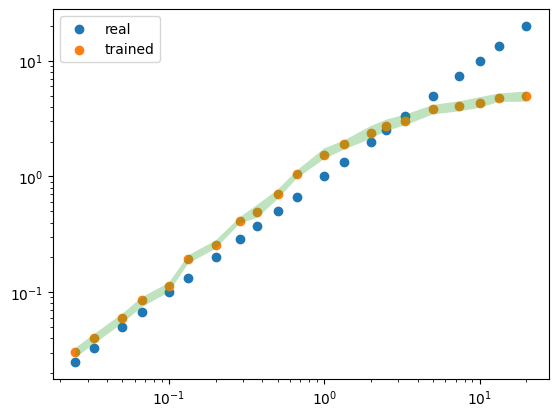

In [40]:
plt.scatter(rs,rs,label='real')
plt.scatter(rs,np.array(Bootstrap_mean),label='trained')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.savefig('regression.png')

In [99]:
def test():
    model.eval()
    predictions = []
    total_loss = 0
    true_values = []
    with torch.no_grad():
        for data in testloader:
            data = data.to(device)
            output = model(data)
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item() * data.num_graphs
            predictions.append(output.cpu())
            true_values.append(data.y.cpu())
    return torch.cat(predictions, dim=0), torch.cat(true_values, dim=0),total_loss / len(testloader.dataset)

In [100]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [101]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 0.5661


In [102]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [ ]:
import pickle

# Assuming 'results' is your dictionary
with open('gnn_regression.pkl', 'wb') as file:
    pickle.dump(results, file)

In [103]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [104]:
CI = np.array(Bootstrap_ci)

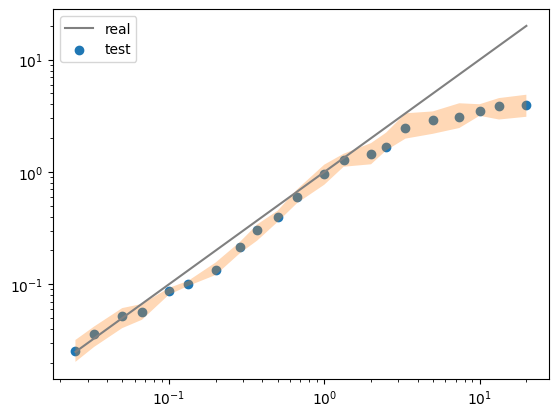

In [105]:
plt.plot(rs,rs,label='real',c='grey')
plt.scatter(rs,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [106]:
rs = rs[::-1]

53
66
61
58
63
54
60
60
75
66
67
51
53
56
61
64
66
64
57
57
48


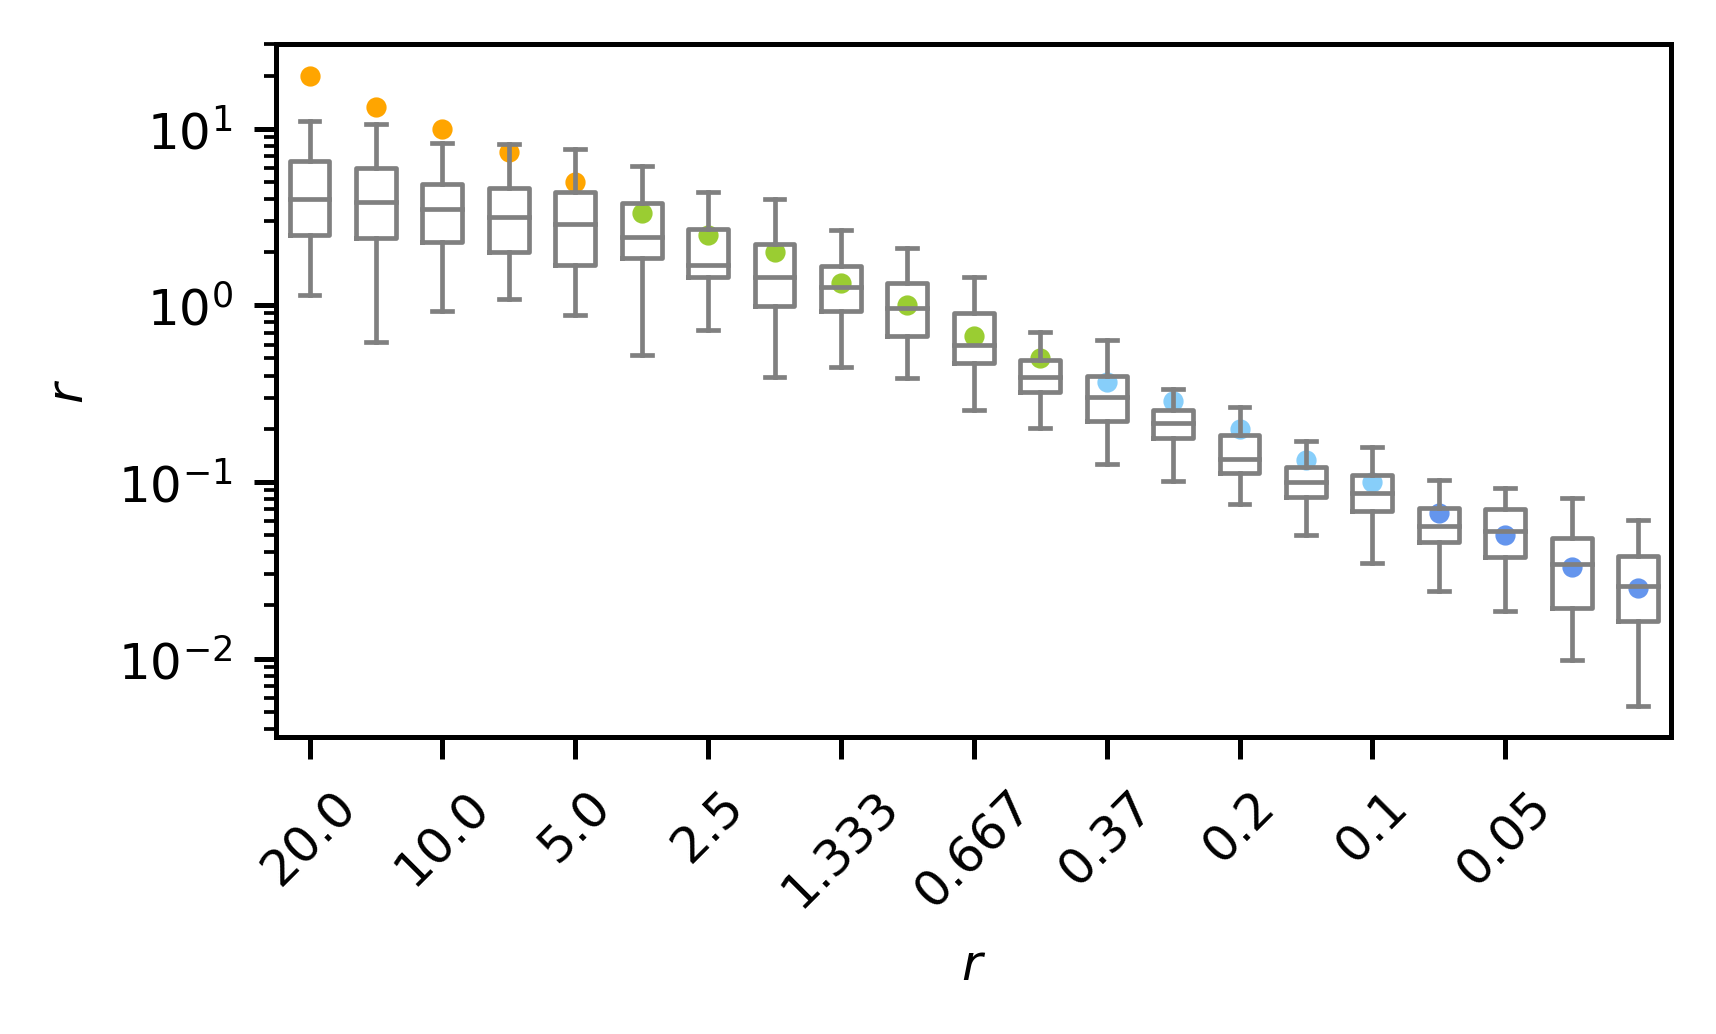

In [109]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,2,4,6,8,10,12,14,16,18])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs[[0,2,4,6,8,10,12,14,16,18]])  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

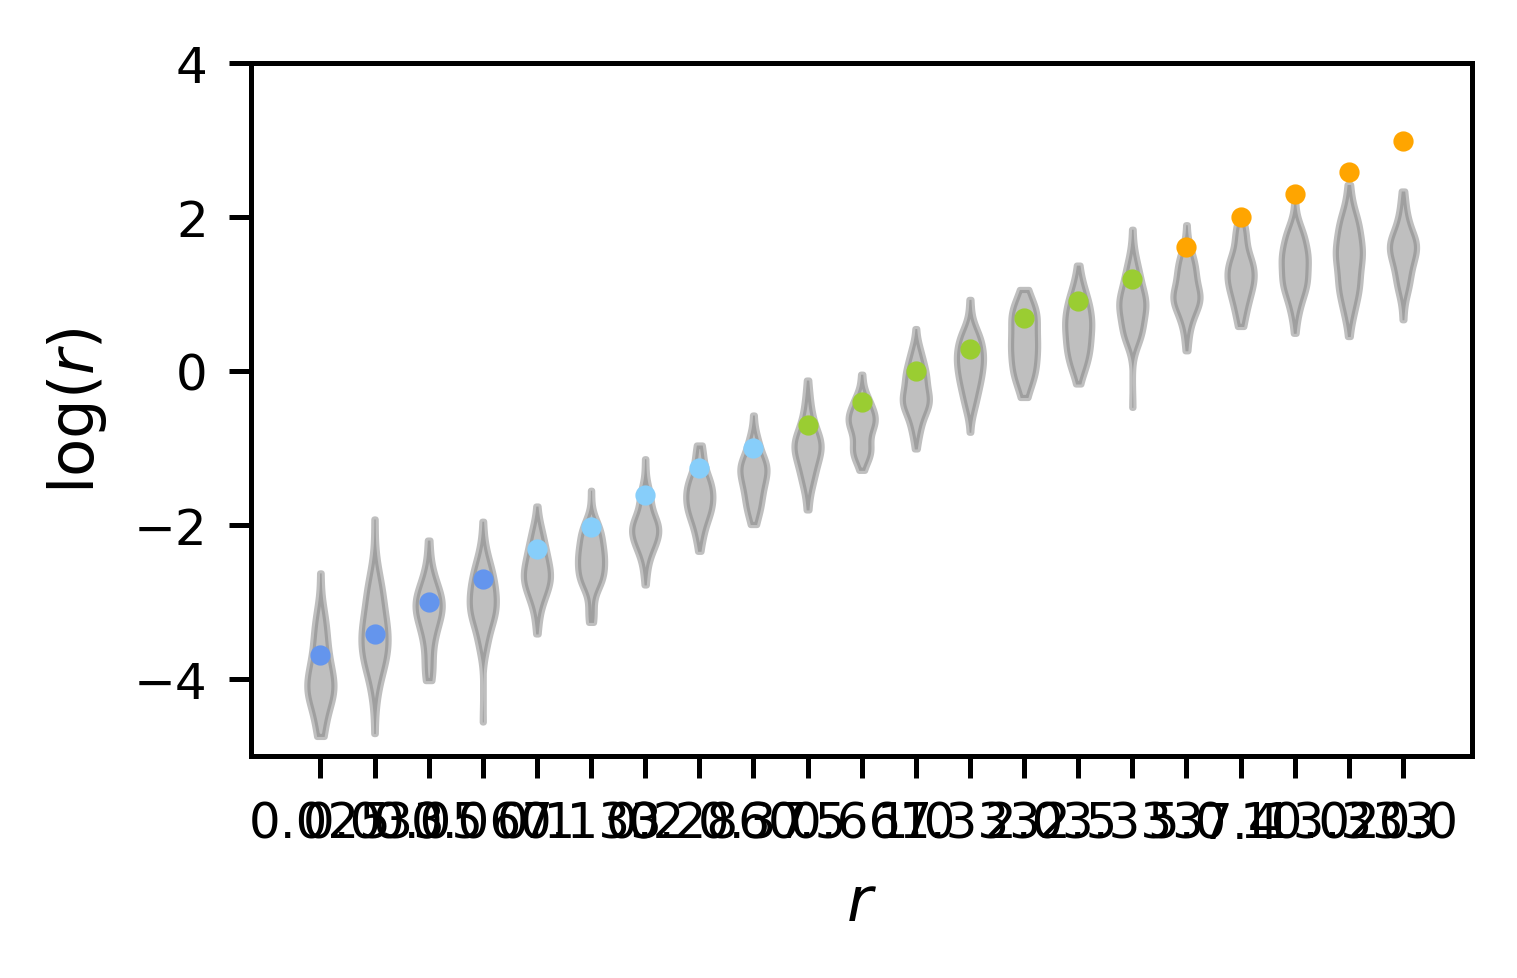

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' and 'rs' are defined as before

fig, ax = plt.subplots(figsize=(3.5,2), dpi=450)

colors = {0:'orange', 1:'yellowgreen', 2:'lightskyblue', 3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    
    # Creating the violin plot at position r_idx + 1
    vp = ax.violinplot(results[r], positions=[r_idx + 1], showmeans=False, showmedians=False, showextrema=False)
    
    # You can set the color of each part of the violin plot
    for pc in vp['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('grey')
        pc.set_alpha(0.5)

    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, k, color=colors[c], s=5)

# Setting x-ticks positions and labels
ax.set_xticks(range(1, 22))
ax.set_xticklabels(rs)

# Setting the limits for y-axis and font size for ticks
plt.ylim(-5, 4)
plt.xlabel('$r$')
plt.ylabel('$\log(r)$')
ax.tick_params(axis='both', labelsize=8)

plt.show()


In [110]:
rs = rs[::-1]

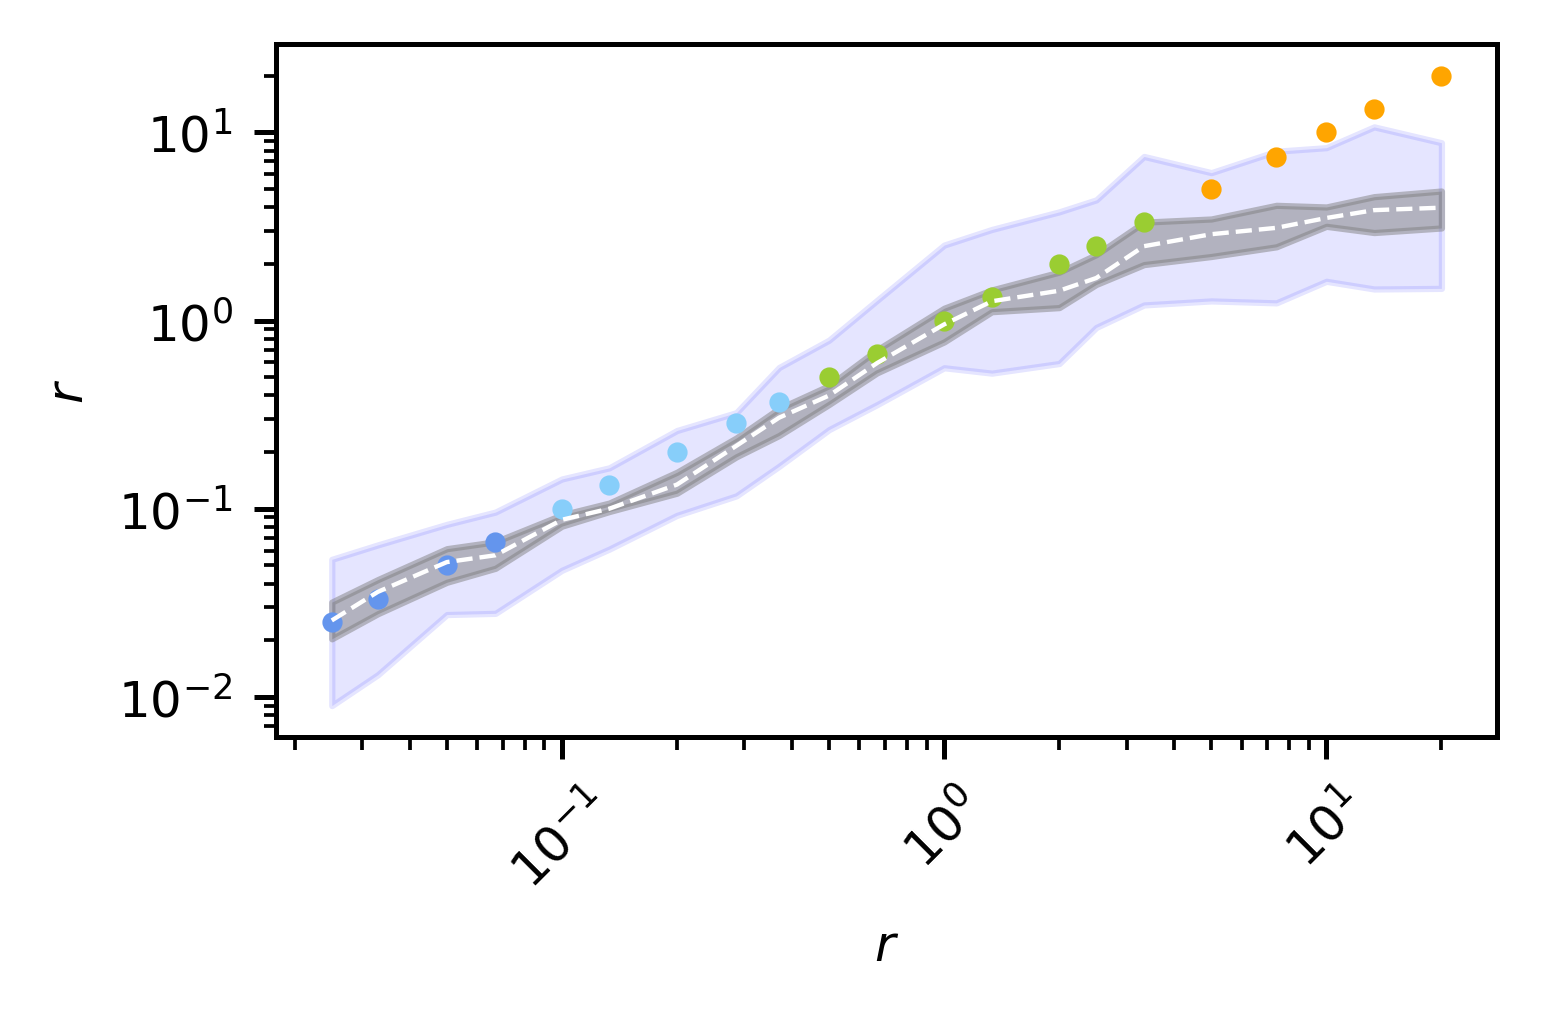

In [111]:
fig, ax = plt.subplots(figsize=(3.5,2),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

line_properties = dict(linestyle='-', linewidth=0.75, color='gray')

# plt.plot(rs,rs,label='real',c='grey')
plt.plot(rs,np.array(Bootstrap_mean),ls='--',lw=0.7,color='white')

plt.fill_between(rs, np.array(per_5),np.array(per_95),
                 alpha=0.1,color='blue')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.5,color='grey')

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
#     real_pr = np.exp(results[r])
#     std_list.append(np.std(real_pr))
#     median_list.append(np.median(real_pr))

    
#     ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
#                boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
#                whiskerprops=line_properties, widths=0.4,
#            capprops=line_properties,
#               medianprops=dict(linestyle='-', linewidth=1, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r, r, color=myc, s=5)

#     print(len(results[r]))
# plt.plot(rs, median_list,ls='--',lw=0.7)

# Show the plot after adding all boxplots
# label_pos = np.array([0,2,4,6,8,10,12,15,16,18])+1
# ax.set_xticks(label_pos)  # Setting x-ticks positions
# ax.set_xticklabels(rs[[0,2,4,6,8,10,12,15,16,18]])  # Assuming 'rs' is your array of labels
plt.xticks(rotation=45)
plt.yscale('log')
plt.xscale('log')
# plt.ylim(-5,4)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

In [112]:
rs_add = np.array([12.5 ,  4.  ,  0.4 ,  0.08])

In [113]:
rs_add = np.array([12.5 ,  4.  ,  0.4 ,  0.08])
export_dir = '/Users/qingyao/Documents/branching_data/simulation/unseen/'
#### data preparation
dataset = []
r_class = {12.5:0 ,  4.:1  ,  0.4:2 ,  0.08:3}
for r_idx in range(4):
    r = rs_add[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:] 
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

12.5 0
4.0 1
0.4 2
0.08 3


In [114]:
testloader = DataLoader(dataset, batch_size=128, shuffle=True)

/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [115]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 0.6851


In [116]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [117]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(4):
    r = rs_add[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

12.5
4.0
0.4
0.08


In [118]:
CI = np.array(Bootstrap_ci)

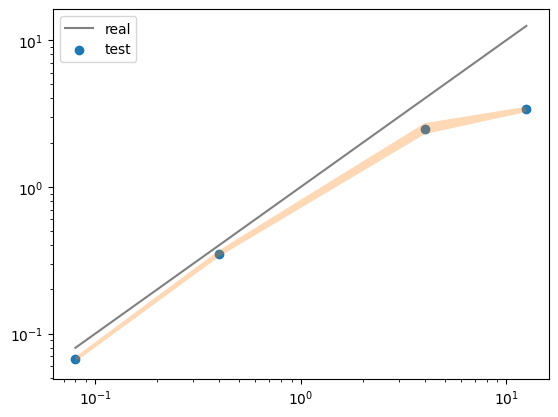

In [119]:
plt.plot(rs_add,rs_add,label='real',c='grey')
plt.scatter(rs_add,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs_add,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

300
300
300
300


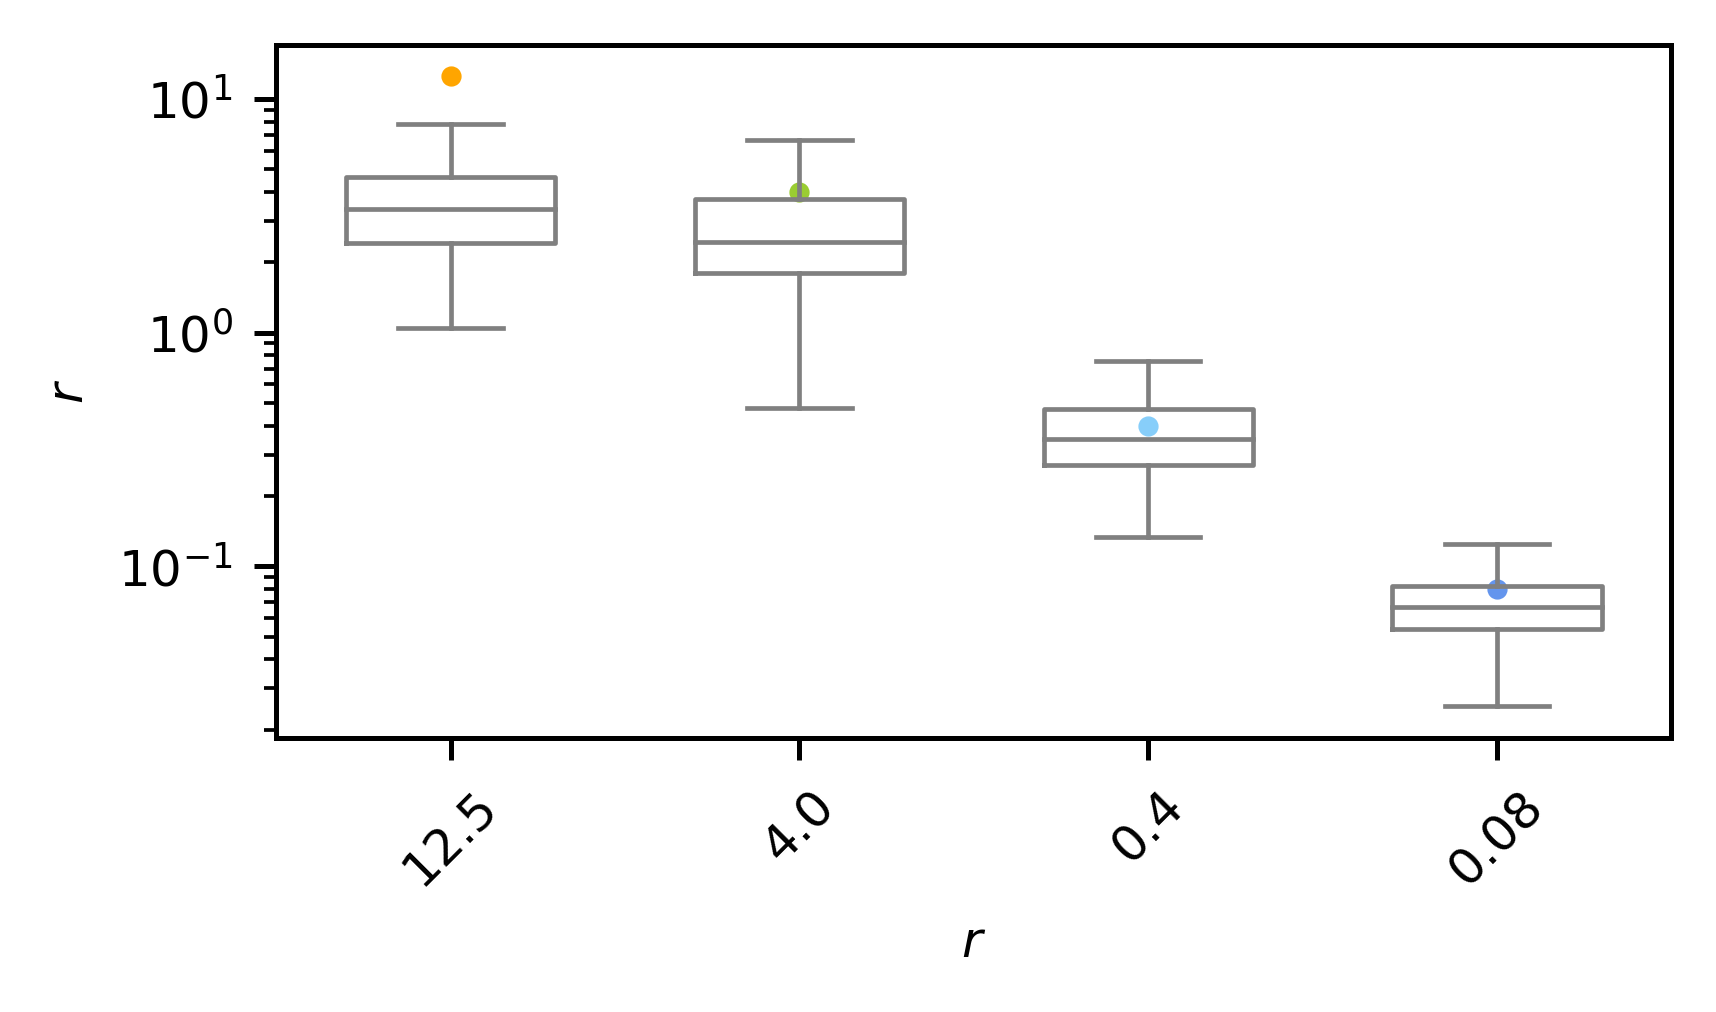

In [120]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
#            5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
#         0.067:3,  0.033:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(4):
    r = rs_add[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,1,2,3])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs_add)  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)